# Importing

In [2]:
%matplotlib notebook

import os
import sys
import time, datetime
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet, load_by_id
from qcodes.dataset.database import initialise_database, get_DB_location
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools

from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id


In [3]:
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

In [4]:
sys.path.append(r"D:\OneDrive\BF3\Code\utils")

import utils
from utils import dic_data
from utils.dic_data import dic2hdf5, data

In [5]:
sys.path.append(r"D:\OneDrive\BF3\Code")  # we do this dirt only for "v2_dataset_tools" package to be on path
from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path


In [480]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists


In [7]:
from data_analysis.tools import curr2cond, smooth

In [8]:
m = 9.11e-31
h = 6.623e-34
h_bar = h/(2*np.pi)
e = 1.602e-19
E_F = 100e-3*e #J
m_eff = 0.023*m

v_F = np.sqrt(2*E_F/m_eff)

G0 = 2*e**2/h

In [9]:
import scipy.optimize as spy

# Load data file and list parameters

In [12]:
dat1 = load_by_id(849)
R_s = 18.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
exc = 20e-6
dat1.get_parameters()

RuntimeError: Expected one row

# 1D plots

## No R_S subtraction

<IPython.core.display.Javascript object>


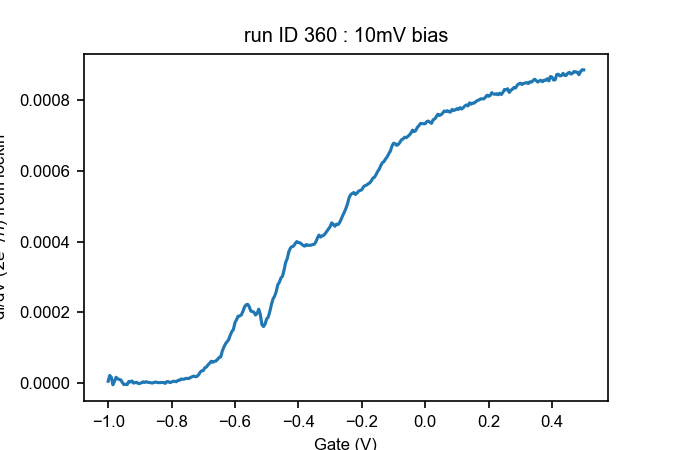

Text(0,0.5,'dI/dV ($2e^2/h$) from lockin')

In [264]:
dat1 = load_by_id(360)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('Lockin1_X'))
plt.figure()
plt.plot(gate_values, current_values)
plt.title('run ID ' + '{}'.format(dat1.run_id)+' : 10mV bias')
plt.xlabel('Gate (V)')
plt.ylabel('dI/dV ($2e^2/h$) from lockin')

<IPython.core.display.Javascript object>


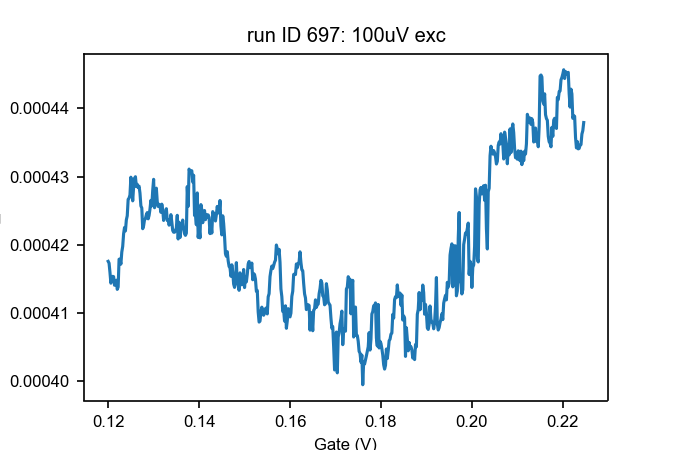

Text(0,0.5,'Lockin1_X (V)')

In [13]:
gate_values = np.array(dat1.get_values('AMI430_x_field'))[600:,0]
current_values = np.array(dat1.get_values('Lockin1_X'))[600:,0]
plt.figure()
plt.plot(gate_values, current_values)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': 100uV exc')
plt.xlabel('Gate (V)')
plt.ylabel('Lockin1_X (V)')

## With $R_s$ subtraction - lock in

<IPython.core.display.Javascript object>


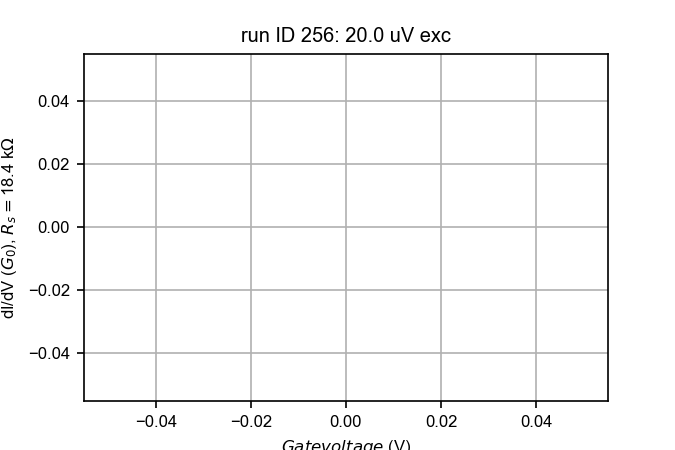

In [371]:
gate_values = np.array(dat1.get_values('AMI430_x_field'))[2600:3000,0]
conductance_values = np.array(dat1.get_values('Lockin1_X'))[2600:3000,0]
res = (exc/(conductance_values/1e6) - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(exc*1e6) + ' uV exc')
plt.xlabel('$B_x$ (T)')
plt.ylabel('dI/dV ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.grid(b=True)
#plt.ylim(-0.5,5)

<IPython.core.display.Javascript object>


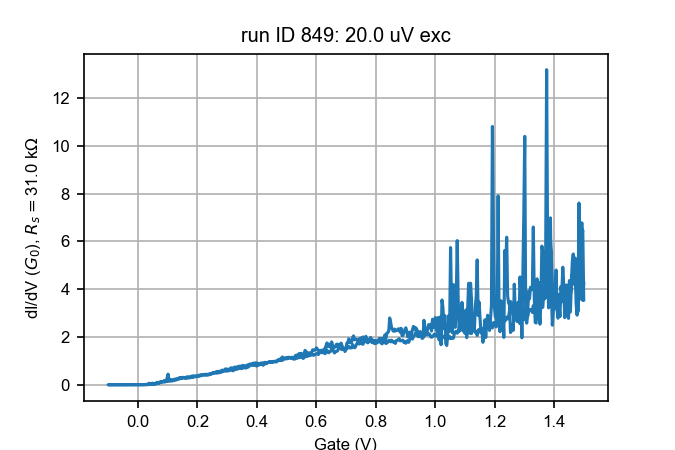

In [40]:
dat1 = load_by_id(849)
R_s = 31e3 # series R in Ohm
exc = 20e-6

gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
conductance_values = np.array(dat1.get_values('Lockin1_R'))[:,0]
res = (exc/(conductance_values/1e6) - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(exc*1e6) + ' uV exc')
plt.xlabel('Gate (V)')
plt.ylabel('dI/dV ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.grid(b=True)

In [22]:
print(np.unique(dat1.get_values('Lockin1_excitation')))

[  1.99999986e-05]


## With $R_s$ subtraction - DC

<IPython.core.display.Javascript object>


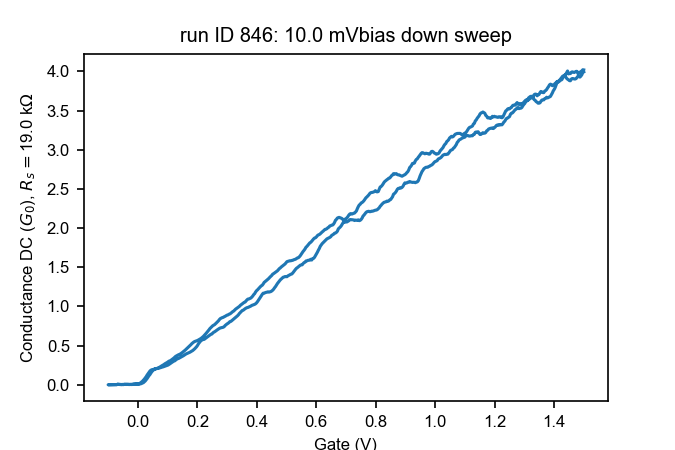

Text(0,0.5,'Conductance DC ($G_0$), $R_s=$19.0 k$\\Omega$')

In [34]:
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_201808_and_older.db')
# automatically uses a different DB file for each month
initialise_database()

dat1 = load_by_id(846)

V_bias = 0.01
R_s = 19e3

gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_values = np.array(dat1.get_values('current'))[:,0]
res = (V_bias/current_values - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(V_bias*1e3) + ' mVbias down sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
#plt.ylim(-0.5,6)

## Up and down sweeps in one run

In [363]:
dat1.run_id

251

<IPython.core.display.Javascript object>


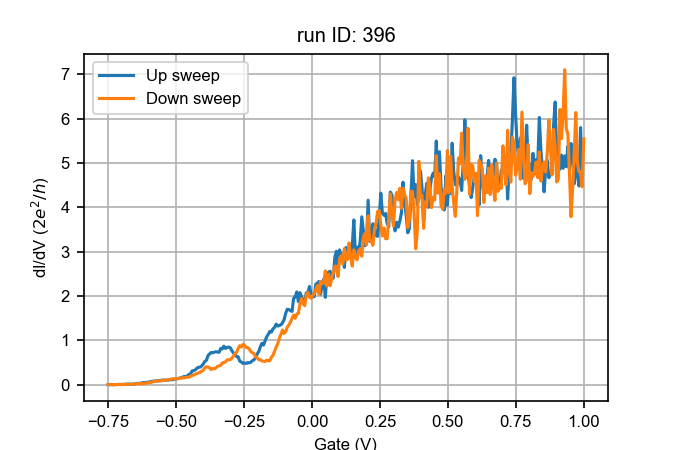

In [306]:
# lockin
dat1 = load_by_id(396)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('conductance'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('testwater')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, label='Up sweep')
plt.plot(gate_down, current_down, label='Down sweep')
# plt.plot(gate_values, current_values, label='Sweep')
plt.xlabel('Gate (V)')
plt.ylabel(r'dI/dV ($2e^2/h$)')
# plt.ylabel('Current (A)')
plt.legend()
plt.grid(b=True)

<IPython.core.display.Javascript object>


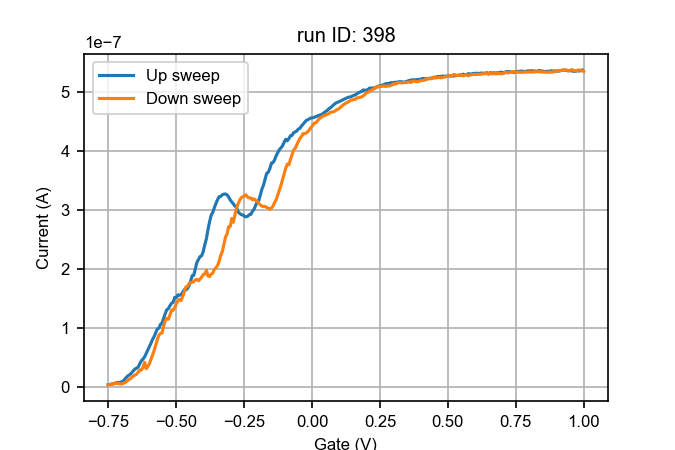

In [308]:
# current
dat1 = load_by_id(398)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('current'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('current up down')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, label='Up sweep')
plt.plot(gate_down, current_down, label='Down sweep')
# plt.plot(gate_values, current_values, label='Sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(b=True)

<IPython.core.display.Javascript object>


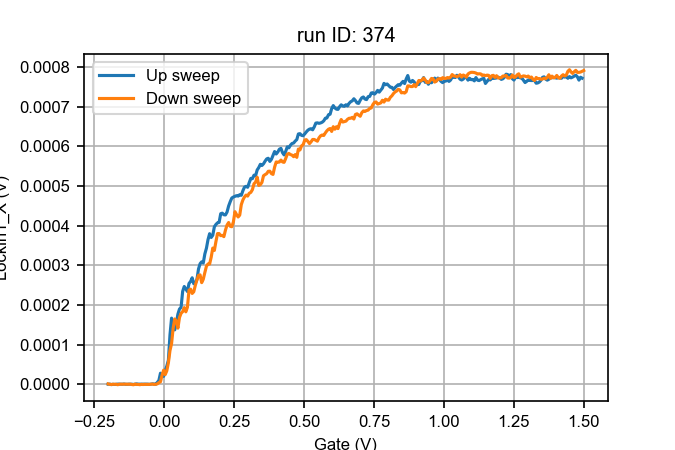

In [271]:
# lockin
dat1 = load_by_id(374)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('Lockin1_X'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('lockin up down')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, label='Up sweep')
plt.plot(gate_down, current_down, label='Down sweep')
# plt.plot(gate_values, current_values, label='Sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Lockin1_X (V)')
plt.legend()
plt.grid(b=True)

## Up and down in two runs

In [29]:
dat1 = load_by_id(602)
dat2 = load_by_id(603)
R_s = 13.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

<IPython.core.display.Javascript object>


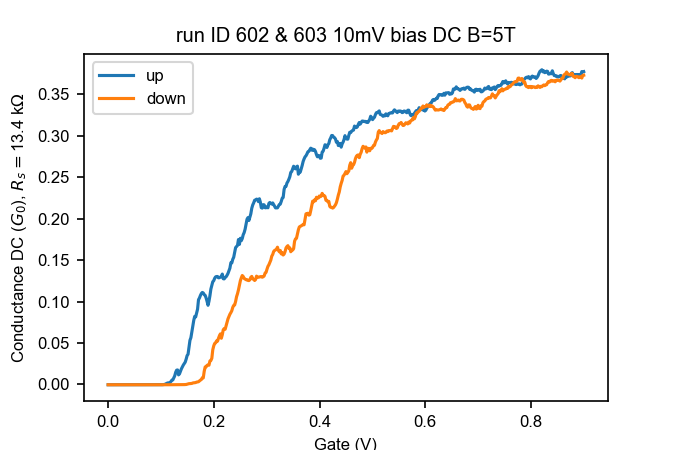

In [30]:
gate_up = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_up = np.array(dat1.get_values('current'))[:,0]
gate_down = np.array(dat2.get_values('mdac_gate_voltage'))[:,0]
current_down = np.array(dat2.get_values('current'))[:,0]

conductance_dc_up = 12906/(V_bias/current_up - R_s)
conductance_dc_down = 12906/(V_bias/current_down - R_s)

plt.figure('10mV hysteresis')
plt.plot(gate_up, conductance_dc_up, gate_down, conductance_dc_down)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' & ' + '{}'.format(dat2.run_id) + ' 10mV bias DC B=5T')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.legend(['up', 'down'])

## gate leakage

<IPython.core.display.Javascript object>


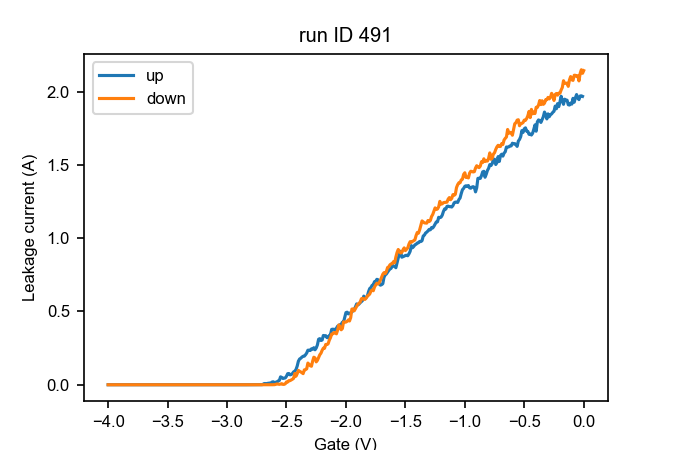

In [577]:
#conductance_up = current_up/(V_bias - current_up*R_s)
#conductance_down = current_down/(V_bias - current_down*R_s)

plt.figure('Leakage current')
plt.plot(gate_up, current_up, gate_down, current_down)
plt.title('run ID ' + '{}'.format(dat1.run_id))
plt.xlabel('Gate (V)')
plt.ylabel('Leakage current (A)')
plt.legend(['up', 'down'])

In [580]:
np.append(np.linspace(4, 0, 8), np.linspace(0, 4, 8))

array([4.        , 3.42857143, 2.85714286, 2.28571429, 1.71428571,
       1.14285714, 0.57142857, 0.        , 0.        , 0.57142857,
       1.14285714, 1.71428571, 2.28571429, 2.85714286, 3.42857143,
       4.        ])

## Pinchoff with $R_s$ correction

To do: add mobility fitting

<IPython.core.display.Javascript object>


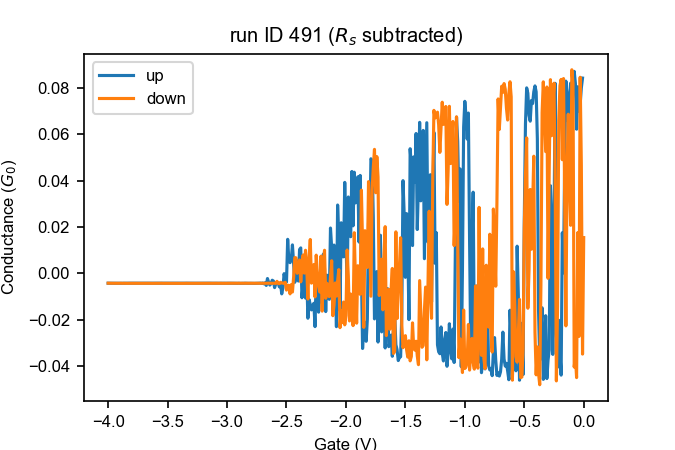

In [575]:
conductance_up = current_up/(V_bias - current_up*R_s)
conductance_down = current_down/(V_bias - current_down*R_s)
plt.figure('conductance minus R_s')
plt.plot(gate_up, conductance_up*12906, gate_down, conductance_down*12906)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' ($R_s$ subtracted)')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance ($G_0$)')
plt.legend(['up', 'down'])

# 2D plots

In [517]:
from qcodes.dataset.experiment_container import Experiment
dat2D = load_by_id(949)
exp = Experiment(dat2D.path_to_db)
exp.exp_id = dat2D.exp_id
dat2D.exp_name = exp.name

R_s = 25.4e3 # series R in Ohm
dat2D.get_parameters()

[mdac_gate_voltage (numeric),
 lockin_dc (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

In [429]:
inner_loop_values = np.unique(dat2D.get_values('lockin_dc'))
outer_loop_values = np.unique(dat2D.get_values('mdac_gate_voltage'))
lockin_X = np.array(dat2D.get_values('conductance'))[:,0].reshape((inner_loop_values.size, outer_loop_values.size))
lockin_X.shape


ValueError: cannot reshape array of size 6832 into shape (201,34)

In [118]:
def colorplot(data, fast_s, slow_s, z, AC='True'):
    fig=plt.figure()
    plt.title('run ID ' + '{}, '.format(data.run_id) + str(dat2D.exp_name)+ ' : 20uV exc')
    #data = data[0]
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    #print((data.get_values(slow_s)))
    data_z = np.array(data.get_values(z))  
    r_line = 18.4e3
    conductance = 12906/(2e-5/(data_z/1e6) - r_line)
    print(min(conductance), max(conductance))
    cmap = plt.cm.seismic #seismic, viridis, magma
    norm = mpl.colors.Normalize(vmin=-0, vmax=3)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('dI/dV ($G_0$)')
    plt.pcolor(np.unique(fs)[::-1]*1e3, np.unique(ss)[::-1], np.reshape(conductance,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap, norm=norm)
    #plt.xlabel(fast_s + ' (V)')
    #plt.ylabel(slow_s + ' (V)')
    plt.xlabel('Bias (mV)')
    plt.ylabel('Gate (V)')
    plt.tight_layout()
    #plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) +'.png')
    #plt.xlim(-0.011,0.011)
    #plt.ylim(0.1,0.3)

<IPython.core.display.Javascript object>


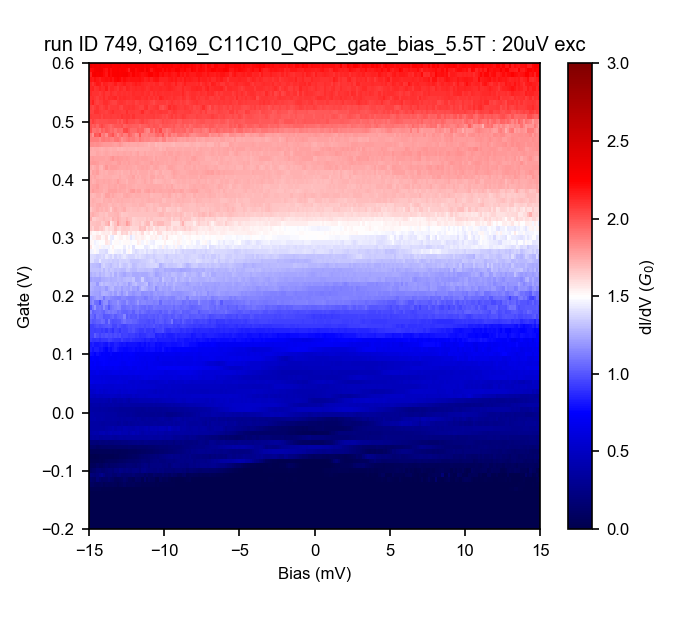

[-0.06762411] [2.34792237]


In [119]:
colorplot(dat2D, 'lockin_dc', 'mdac_gate_voltage', 'Lockin1_X')

## 1D from 2D plot

In [290]:
def plot1D_from_2D(data, x, y, x2, index):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    print(b)
    npoints = len(b)
    v2 = np.array(data.get_values(x2))
    x2_value = v2[index*npoints]
    points = v2 == v2[index*npoints]#x2_value #np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    
    #plt.plot(points)
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    #print(b, g)
    print(x2_value)
    plt.plot(b, g[::-1], label=x2+' = '+str(x2_value)[1:4]+' T')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) + '_%.3fT.png'%(x2_value))
    
    #return b #, g_sub

<IPython.core.display.Javascript object>


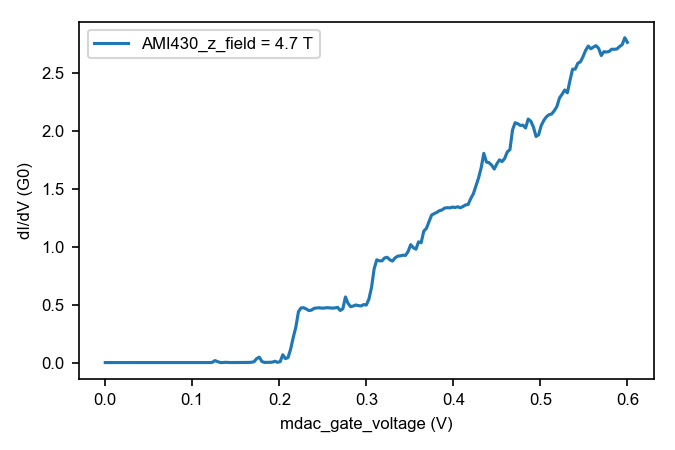

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03  0.033
 0.036 0.039 0.042 0.045 0.048 0.051 0.054 0.057 0.06  0.063 0.066 0.069
 0.072 0.075 0.078 0.081 0.084 0.087 0.09  0.093 0.096 0.099 0.102 0.105
 0.108 0.111 0.114 0.117 0.12  0.123 0.126 0.129 0.132 0.135 0.138 0.141
 0.144 0.147 0.15  0.153 0.156 0.159 0.162 0.165 0.168 0.171 0.174 0.177
 0.18  0.183 0.186 0.189 0.192 0.195 0.198 0.201 0.204 0.207 0.21  0.213
 0.216 0.219 0.222 0.225 0.228 0.231 0.234 0.237 0.24  0.243 0.246 0.249
 0.252 0.255 0.258 0.261 0.264 0.267 0.27  0.273 0.276 0.279 0.282 0.285
 0.288 0.291 0.294 0.297 0.3   0.303 0.306 0.309 0.312 0.315 0.318 0.321
 0.324 0.327 0.33  0.333 0.336 0.339 0.342 0.345 0.348 0.351 0.354 0.357
 0.36  0.363 0.366 0.369 0.372 0.375 0.378 0.381 0.384 0.387 0.39  0.393
 0.396 0.399 0.402 0.405 0.408 0.411 0.414 0.417 0.42  0.423 0.426 0.429
 0.432 0.435 0.438 0.441 0.444 0.447 0.45  0.453 0.456 0.459 0.462 0.465
 0.468 0.471 0.474 0.477 0.48  0.483 0.486 0.489 0.

In [307]:
plt.figure()

#dat2D.get_parameters()#values('conductance')
plot1D_from_2D(dat2D, 'mdac_gate_voltage', 'conductance', 'AMI430_z_field', 7)
dat2D.run_id = 615


In [35]:
10e-3/5e-7

20000.0

In [17]:
plot1D_from_2D(dat1, 'gate_voltage', 'dI', 'bias_voltage', 0.003)

## View gate or bias setpoints

In [123]:
np.unique(dat2D.get_values('lockin_dc'))

array([-0.015  , -0.01485, -0.0147 , -0.01455, -0.0144 , -0.01425,
       -0.0141 , -0.01395, -0.0138 , -0.01365, -0.0135 , -0.01335,
       -0.0132 , -0.01305, -0.0129 , -0.01275, -0.0126 , -0.01245,
       -0.0123 , -0.01215, -0.012  , -0.01185, -0.0117 , -0.01155,
       -0.0114 , -0.01125, -0.0111 , -0.01095, -0.0108 , -0.01065,
       -0.0105 , -0.01035, -0.0102 , -0.01005, -0.0099 , -0.00975,
       -0.0096 , -0.00945, -0.0093 , -0.00915, -0.009  , -0.00885,
       -0.0087 , -0.00855, -0.0084 , -0.00825, -0.0081 , -0.00795,
       -0.0078 , -0.00765, -0.0075 , -0.00735, -0.0072 , -0.00705,
       -0.0069 , -0.00675, -0.0066 , -0.00645, -0.0063 , -0.00615,
       -0.006  , -0.00585, -0.0057 , -0.00555, -0.0054 , -0.00525,
       -0.0051 , -0.00495, -0.0048 , -0.00465, -0.0045 , -0.00435,
       -0.0042 , -0.00405, -0.0039 , -0.00375, -0.0036 , -0.00345,
       -0.0033 , -0.00315, -0.003  , -0.00285, -0.0027 , -0.00255,
       -0.0024 , -0.00225, -0.0021 , -0.00195, -0.0018 , -0.00

## Exporting data

In [31]:
with open("B11B12 conductance_up.txt", "w") as text_file:
    for value in conductance_dc_up:
        text_file.write(str(value) + '\n')
with open("B11B12 conductance_down.txt", "w") as text_file:
    for value in conductance_dc_down:
        text_file.write(str(value) + '\n')

        
#with open("B13B14 gate_up.txt", "w") as text_file:
#    for value in gate_up:
#        text_file.write(str(value) + '\n')
#with open("B13B14 gate_down.txt", "w") as text_file:
#    for value in gate_down:
#        text_file.write(str(value) + '\n')


## 2D Coulomb diamond plots

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


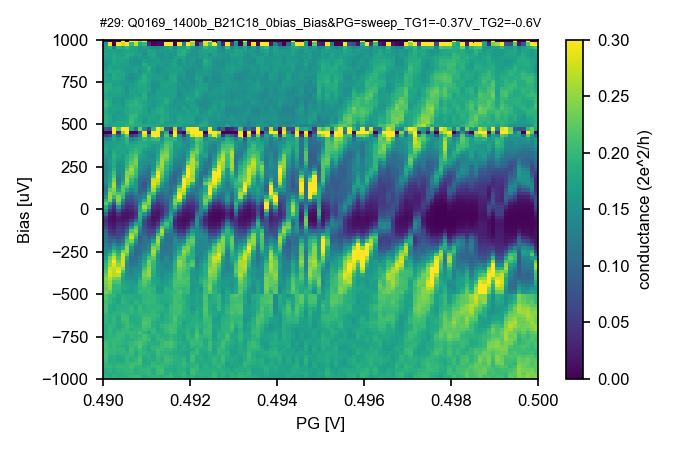

In [693]:
data = load_by_id(29);

PG = data.get_values('mdac_PG');

dim_guess = sum([1*(PG[0] == g) for g in PG]);
dims = [dim_guess, int(len(PG) / dim_guess)];

PG = np.array(PG)[:,0].reshape(*dims);
bias = np.array(data.get_values('lockin_dc'))[:,0].reshape(*dims);
G = np.array(data.get_values('conductance'))[:,0].reshape(*dims);

plt.figure('diamonds');
plt.pcolor(PG, bias * 1E6, G, vmin = 0, vmax = 0.3);
plt.colorbar().set_label('conductance (2e^2/h)');
plt.xlabel('PG [V]');
plt.ylabel('Bias [uV]');
plt.title('#' + str(data.run_id) +': ' + data.exp_name, fontsize = 6);

## 2D QPC diamond plots

### Gate-bias

<IPython.core.display.Javascript object>


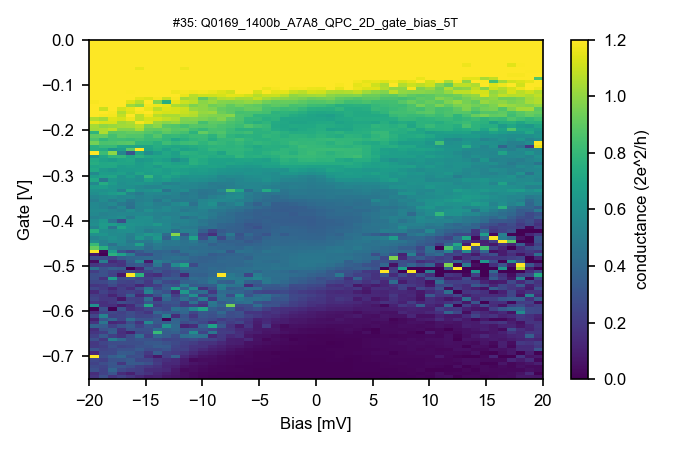

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


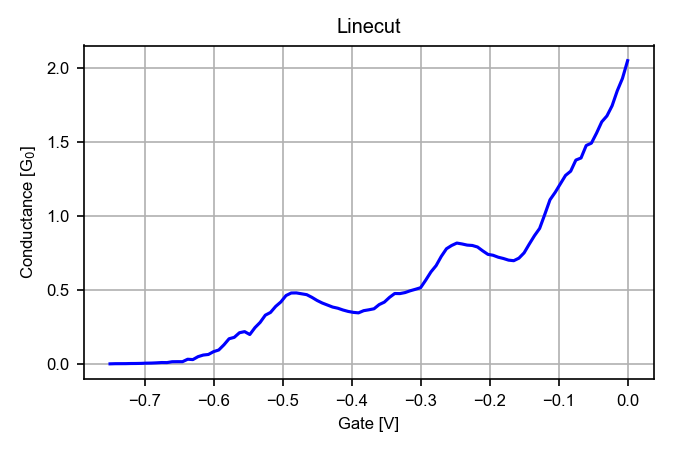

In [704]:
import scipy.ndimage
data = load_by_id(35);
lockin = np.array(data.get_values('lockin_dc'))[:,0];
gate = np.array(data.get_values('mdac_gate_voltage'))[:,0];
G = np.array(data.get_values('conductance'))[:,0];

dim_guess = sum([1*(lockin[0] == g) for g in lockin]);
dims = [dim_guess, int(gate.size / dim_guess)];

lockin = lockin.reshape(*dims);
gate = gate.reshape(*dims);
G = G.reshape(*dims);

plt.figure('qpc_diamonds');
plt.pcolor(lockin * 1e3, gate, G, vmin = 0, vmax = 1.2);
# plt.pcolor(lockin * 1e3, gate, G, vmin = 0, vmax = 1.2, cmap = 'seismic');
plt.colorbar().set_label('conductance (2e^2/h)');
plt.xlabel('Bias [mV]');
plt.ylabel('Gate [V]');
plt.title('#' + str(data.run_id) +': ' + data.exp_name, fontsize = 6);

# Constant bias linecuts
Vgi = np.unique(gate);
Vb0, Vg0 = int(dims[1] / 4 * 2), dims[0]; # pixel coords
Vb1, Vg1 = int(dims[1] / 4 * 2), 0; # pixel coords
x, y = np.linspace(Vg0, Vg1, Vgi.size), np.linspace(Vb0, Vb1, Vgi.size); # original data is 90 deg rotated
Gi = scipy.ndimage.map_coordinates(G, np.vstack((x,y)))

plt.figure('qpc_diamonds_linecuts');
plt.plot(Vgi, Gi, 'b');
plt.xlabel('Gate [V]');
plt.ylabel('Conductance [G$_0$]');
plt.title('Linecut')#at V$_b$ = '+str(np.array(bias).tolist()[0][Vb0])+' [V]');
plt.grid(True);

### Gate-field

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


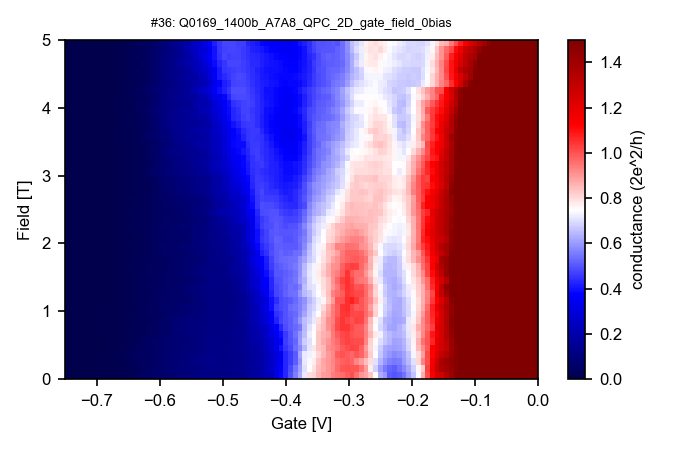

In [705]:
data = load_by_id(36);
gate = np.array(data.get_values('mdac_gate_voltage'))[:,0];
field = np.array(data.get_values('AMI430_z_field'))[:,0];
G = np.array(data.get_values('conductance'))[:,0];

dim_guess = sum([1*(gate[0] == g) for g in gate]);
dims = [dim_guess, int(gate.size / dim_guess)];

gate = gate.reshape(*dims);
field = field.reshape(*dims);
G = G.reshape(*dims);

plt.figure('qpc_field');
plt.pcolor(gate, field, G, vmin = 0, vmax = 1.5, cmap = 'seismic');
plt.colorbar().set_label('conductance (2e^2/h)');
plt.xlabel('Gate [V]');
plt.ylabel('Field [T]');
plt.title('#' + str(data.run_id) +': ' + data.exp_name, fontsize = 6);

### 3D plots

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


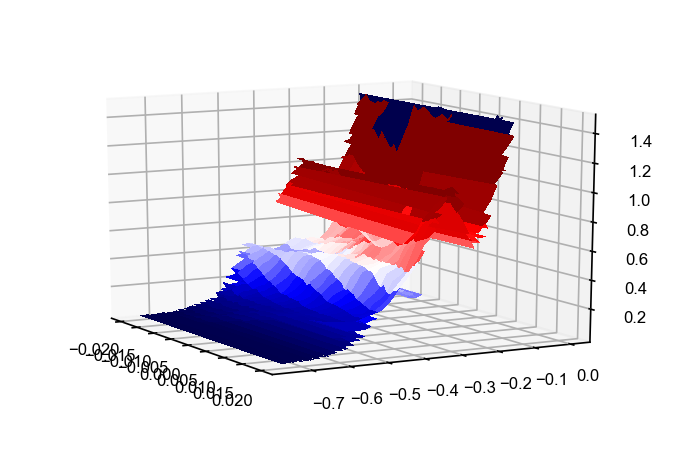

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


In [709]:
from mpl_toolkits.mplot3d import Axes3D

data = load_by_id(36);
field = np.array(data.get_values('AMI430_z_field'))[:,0];
gate = np.array(data.get_values('mdac_gate_voltage'))[:,0];
G = np.array(data.get_values('conductance'))[:,0];

dim_guess = sum([1*(gate[0] == g) for g in gate]);
dims = [dim_guess, int(gate.size / dim_guess)];

lockin = lockin.reshape(*dims);
gate = gate.reshape(*dims);
G = G.reshape(*dims);

fig = plt.figure('qpc_3d')
ax = fig.gca(projection='3d')
G[G>1.5] = np.nan;
G[G<0.001] = np.nan;
surf = ax.plot_surface(lockin, gate, G, cmap='seismic', vmin = 0, vmax = 1, linewidth=0, antialiased=False)

### Multiple pinchoffs single graph

<IPython.core.display.Javascript object>


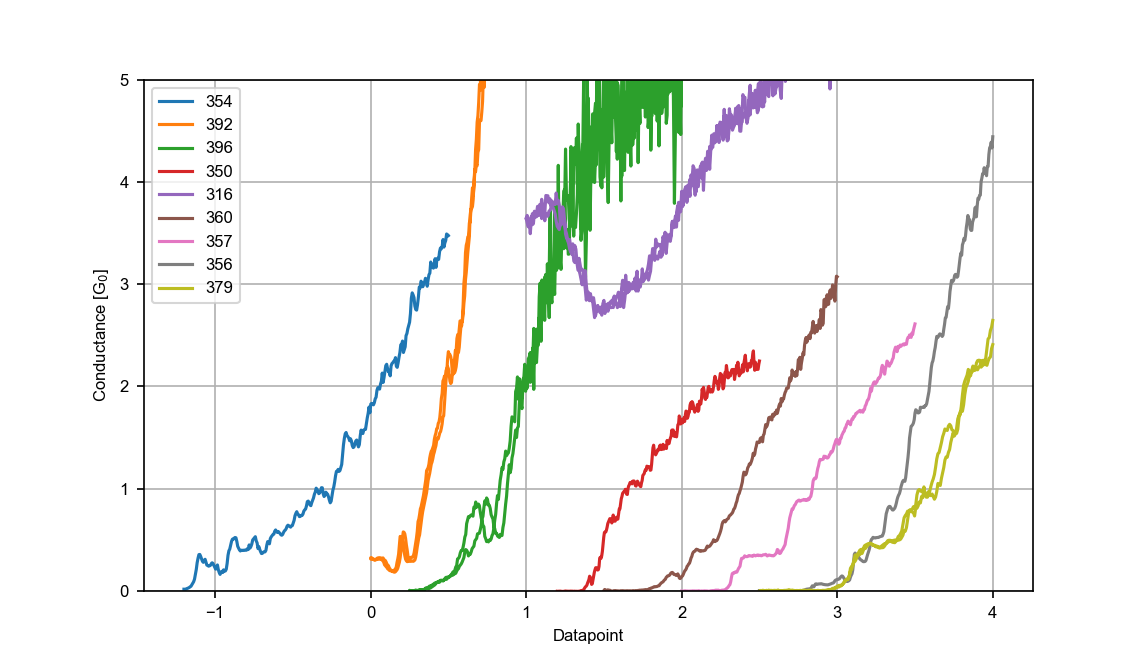

In [471]:
ids = [354, 392, 396, 350, 316, 360, 357, 356, 379];
offset = 0.5;

plt.figure('qpc_multi_pinchoff');
for num, i in enumerate(ids):
    data = load_by_id(i);
    G = np.array(data.get_values('conductance'))[:,0];
    gate = np.array(data.get_values('mdac_gate_voltage'))[:,0];
    
    plt.plot(gate + offset * num, G);
    
plt.xlabel('Datapoint');
plt.ylabel('Conductance [G$_0$]');
plt.grid(True);
plt.ylim([0, 5])
plt.legend(ids);

# AB oscillations

In [10]:
dat_AB = load_by_id(148)
R_s = 18.4e3 # series R in Ohm
V_bias = 0 #bias voltage in V
dat_AB.get_parameters()

[field_sweep (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric),
 B_x (numeric)]

<IPython.core.display.Javascript object>


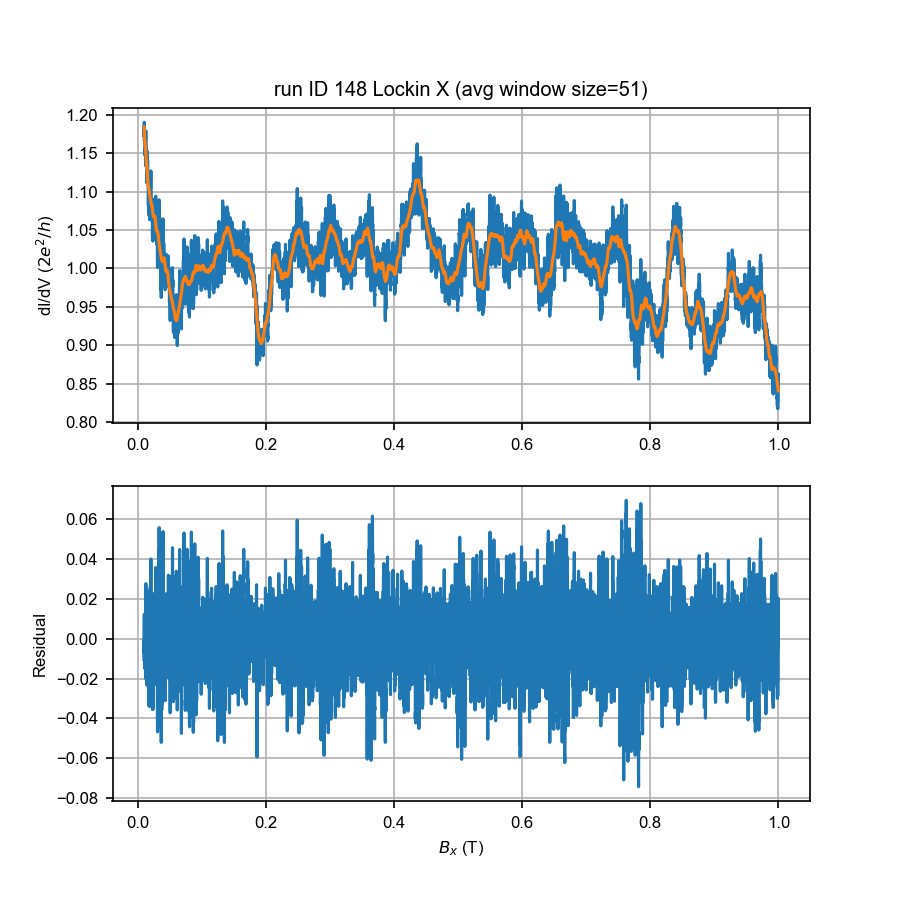

In [11]:
B_values = np.array(dat_AB.get_values('B_x'))[:,0]
B_min, B_max = min(B_values), max(B_values)
npoints = B_values.size
conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]

avg_window_size = 51
conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
conductance_residual = conductance_values - conductance_background

plt.figure('fft background', figsize=(6,6))
plt.subplot(211)
plt.plot(B_values, conductance_values, B_values, conductance_background)
plt.grid(b=True)
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' Lockin X (avg window size=' + str(avg_window_size) + ')')
plt.ylabel('dI/dV ($2e^2/h$)')
plt.subplot(212)
plt.plot(B_values, conductance_residual)
plt.ylabel('Residual')
plt.xlabel('$B_x$ (T)')
plt.grid(b=True)

<IPython.core.display.Javascript object>


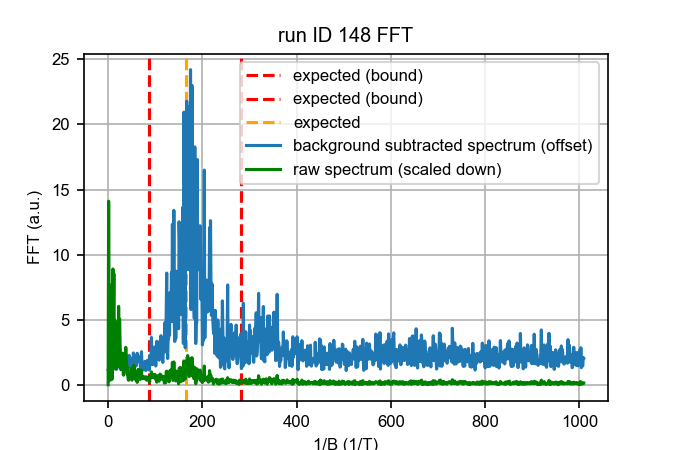

In [12]:
# FFT
n_cutoff = 1000

fft_ab = np.fft.fft(conductance_residual)
fft_non_avgd = np.fft.fft(conductance_values - conductance_values.mean())
B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)

plt.figure('abfft')
plt.axvline(x=85.8, color='red', linestyle='dashed')
plt.axvline(x=283, color='red', linestyle='dashed')
plt.axvline(x=165, color='orange', linestyle='dashed')
plt.plot(B_inv[:n_cutoff], np.abs(fft_ab)[:n_cutoff]+1)
plt.plot(B_inv[:n_cutoff], 0.1*np.abs(fft_non_avgd)[:n_cutoff], color='green')
plt.xlabel('1/B (1/T)')
plt.ylabel('FFT (a.u.)')
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' FFT')
plt.legend(['expected (bound)', 'expected (bound)', 'expected', 'background subtracted spectrum (offset)', 'raw spectrum (scaled down)'])
plt.grid(b=True)

## Averaging FFTs

<IPython.core.display.Javascript object>


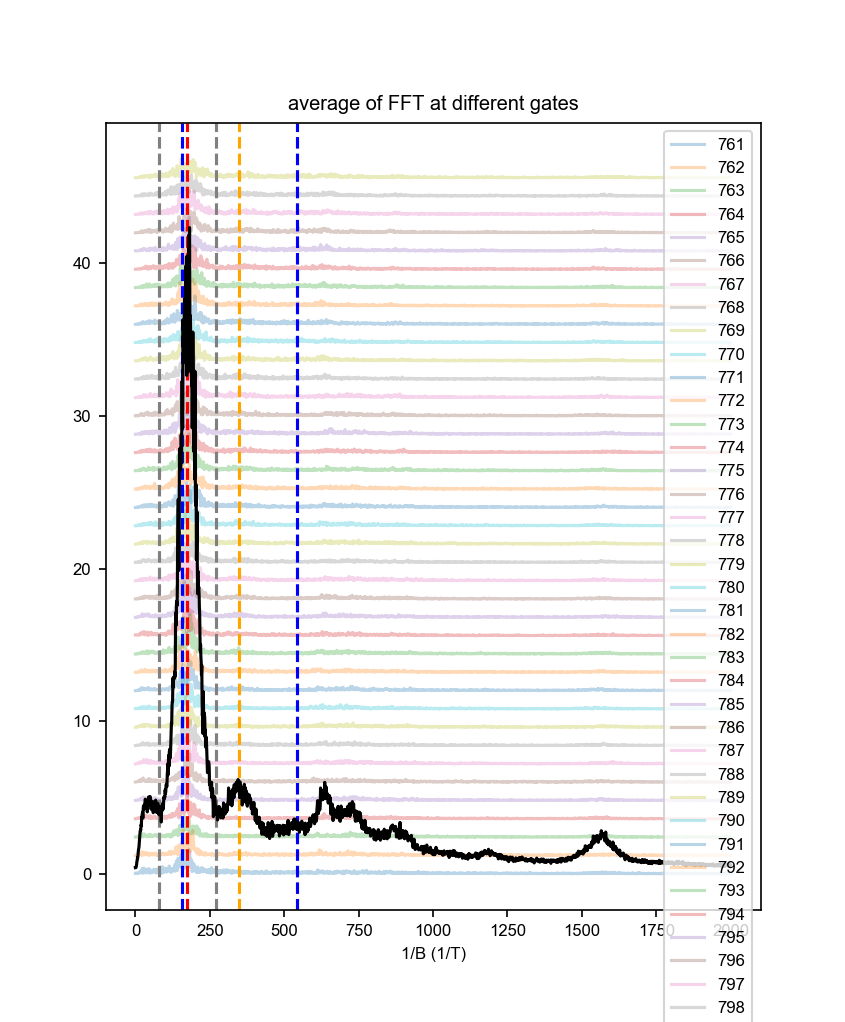

In [100]:
from scipy.signal import savgol_filter

# Lets look at the August data
qc.config["core"]["db_location"] = r'D:\OneDrive\BF3\Data\experiments_201808_and_older.db';
initialise_database();

data_id_list = range(761, 800)
# data_id_list = range(861,874)
# data_id_list = range(920,940)
number_points_list = [4000,4000,4000,4000]
n_cutoff = 2000

B_inv_unified = np.linspace(0,2000,2001)
fft_avg = np.zeros(B_inv_unified.shape)

plt.figure('all AB raw')

counter = 0
for data_id in data_id_list:
    dat_AB = load_by_id(data_id)
    B_values = np.array(dat_AB.get_values('B_x'))[:4000,0]
    B_min, B_max = min(B_values), max(B_values)
    npoints = B_values.size
    conductance_values = np.array(dat_AB.get_values('Lockin1_X'))[:4000,0]

    avg_window_size = 31
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    fft_ab = np.abs(np.fft.fft(conductance_residual))
    B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)
    
    B_inv_unified
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    fft_avg += fft_ab_intp
    
    plt.plot(B_inv_unified, 50*fft_ab_intp + 1.2*counter, alpha = 0.3)
    counter += 1

plt.legend(list(map(str, data_id_list)))
fft_avg /= len(data_id_list)
fft_scalar = 2000;
plt.axvline(x=78, color='grey', linestyle = 'dashed')
plt.axvline(x=271, color='grey', linestyle = 'dashed')
plt.axvline(x=156, color='blue', linestyle = 'dashed') # second order width estimate
plt.axvline(x=542, color='blue', linestyle = 'dashed') # second order width estimate
plt.axvline(x=174, color='red', linestyle = 'dashed')
plt.axvline(x=2*174, color='orange', linestyle = 'dashed')
plt.plot(B_inv_unified, fft_avg*fft_scalar, color = 'black')
# plt.plot(B_inv_unified, savgol_filter(fft_avg*fft_scalar, 31, 3), color = 'black')
plt.title('average of FFT at different gates')
plt.xlabel('1/B (1/T)')

# Restore db filepath
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_%Y-%m.db')
initialise_database();

## Temperature dependence

<IPython.core.display.Javascript object>


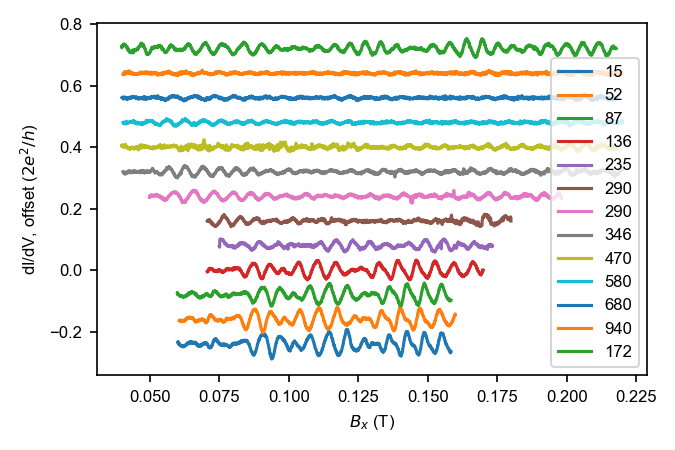

(1610,)
(1621,)
(1614,)
(1629,)
(1596,)
(1782,)
(2420,)
(2934,)
(2890,)
(2925,)
(2893,)
(2921,)
(2878,)


In [79]:
# plotting B curves
plt.figure('temp dep')
plt.xlabel('$B_x$ (T)')
plt.ylabel('dI/dV, offset ($2e^2/h$)')

T_list = [15,52,87,136,235,290,290,346,470,580,680,940, 172]
for i in range(1007, 1020):
    dat_AB = load_by_id(i)
    B_values = np.array(dat_AB.get_values('B_x'))[:,0]
    conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]
    
    print(B_values.shape)
    
    avg_window_size = 101
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 101 points ~ 5mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    plt.plot(B_values, conductance_residual + 0.08*(i-1010))
    
plt.legend(T_list)

<IPython.core.display.Javascript object>


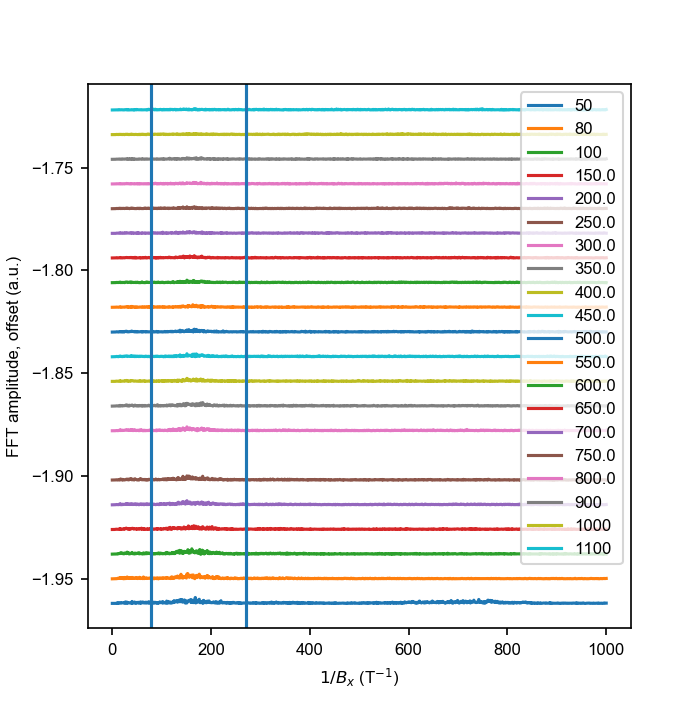

(7668,)
(7728,)
(7670,)
(7745,)
(7703,)
(7727,)
(7752,)
(7747,)
(7693,)
(7741,)
(7732,)
(7705,)
(7734,)
(7714,)
(7744,)
(7713,)
(7728,)
(7759,)
(7735,)
(7748,)


In [346]:
plt.figure('temp dep fft')
plt.xlabel('$1/B_x$ (T$^{-1}$)')
plt.ylabel('FFT amplitude, offset (a.u.)')
B_inv_unified = np.linspace(0,1000,1001)
amp_list = []

T_list = [50, 80, 100] + list(np.linspace(150,800, 14)) + [900, 1000, 1100];
for i in np.array([24, 30, 36, 42, 48, 54, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144]) +5:
    dat_AB = load_by_id(i)
    B_values = np.array(dat_AB.get_values('B_x'))[:,0]
    conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]
    
    print(B_values.shape)
    
    avg_window_size = 101
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 101 points ~ 5mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    fft_ab = np.abs(np.fft.fft(conductance_residual))/len(conductance_residual)
    B_inv = np.linspace(0, B_values.size/(max(B_values)-min(B_values)), B_values.size)
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    
    plt.plot(B_inv_unified, fft_ab_intp + 2e-3*(i-1010))
    amp_list.append(np.sum(fft_ab_intp[78:271])) # 85:283
    
plt.legend(T_list)
plt.axvline(x=78)
plt.axvline(x=271)

### Assuming ballistic transport

This means $l_\phi \propto T^{-1}$. However, this is probably not a valid assumption since our $L>>$ mean free path.

<IPython.core.display.Javascript object>


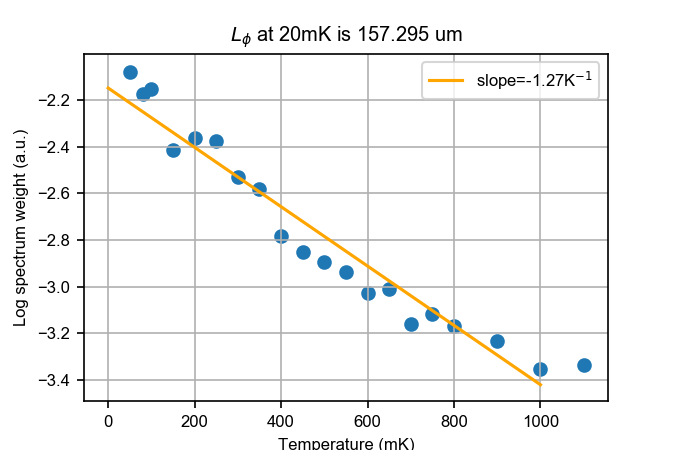

$L_\phi$ at 20mK is 157.295 um


In [347]:
plt.figure('t vs amp')
plt.scatter(T_list, np.log(amp_list))
plt.grid(b=True)
linfit_a, linfit_b = np.polyfit(T_list, np.log(amp_list), deg=1)
x = np.arange(0,1100,100)
plt.plot(x, linfit_a * x + linfit_b, color='orange')
plt.legend(['slope='+'{:.2f}'.format(linfit_a*1e3, )+'K$^{-1}$'])
plt.xlabel('Temperature (mK)')
plt.ylabel('Log spectrum weight (a.u.)')

l_str = '$L_\phi$ at 20mK is {:.3f} um'.format(np.abs(L/linfit_a/20));
plt.title(l_str);

L = 4 # circumference in um
print(l_str)

### Assuming diffusive transport

In this case $l_\phi \propto T^{-1/2}$. Thus the AB amplitude is expressed as 

$$A_{h/e} = A_0 \exp\left(-aT^{1/2}\right)$$

We fit the relation between $T$ and $\log(A_{h/e})$ to obtain $A_0$ and $a$, and then 

$$ l_\phi = \frac{L}{a\sqrt{T}} $$

<IPython.core.display.Javascript object>


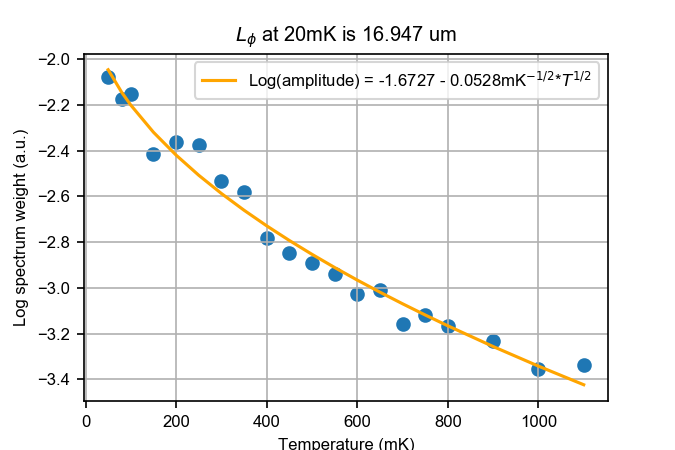

$L_\phi$ at 20mK is 16.947 um


In [348]:
from scipy.optimize import curve_fit

def logA_T(T, logA0, a):
    return logA0 - np.sqrt(T)*a

popt, pcov = curve_fit(logA_T, T_list, np.log(amp_list))
perr = np.sqrt(np.diag(pcov))
plt.figure('diffusive T dependence')
plt.scatter(T_list, np.log(amp_list))
plt.plot(np.sort(T_list), logA_T(np.sort(T_list), popt[0], popt[1]), color='orange')
plt.grid(b=True)
plt.legend(['Log(amplitude) = {:.4f} - {:.4f}mK$^{{-1/2}}$*$T^{{1/2}}$'.format(popt[0], popt[1])])
plt.xlabel('Temperature (mK)')
plt.ylabel('Log spectrum weight (a.u.)')

l_str = '$L_\phi$ at 20mK is {:.3f} um'.format(L/popt[1]/np.sqrt(20));
plt.title(l_str);

L = 4 # circumference in um
print(l_str)

## Raw plotting

<IPython.core.display.Javascript object>


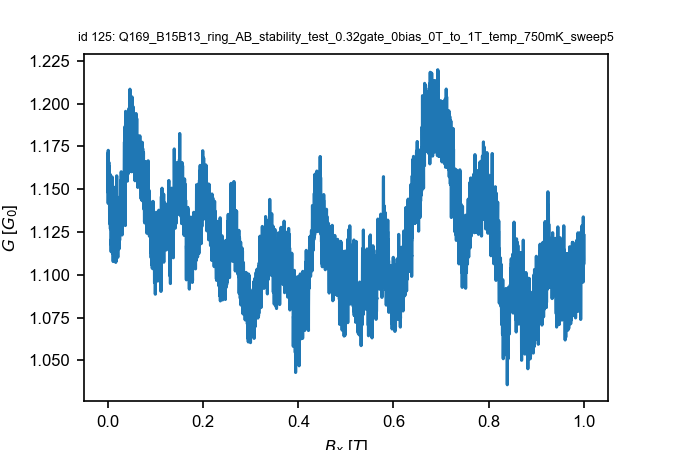

<IPython.core.display.Javascript object>


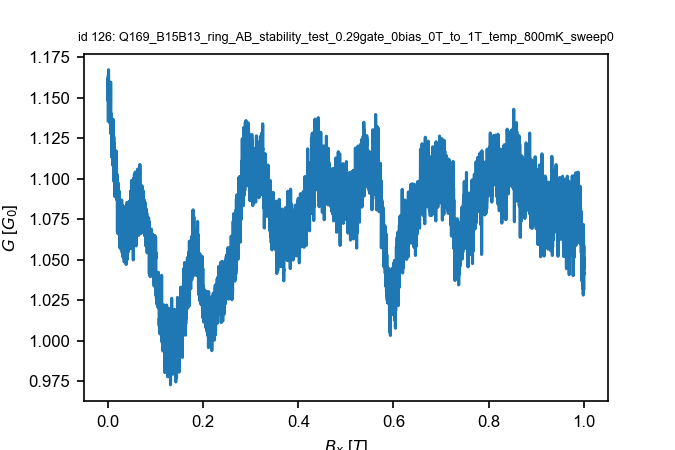

In [60]:
for i in range(125, 126 +1):
    
    dat_AB = load_by_id(i);
    B_x = dat_AB.get_values('B_x');
    G = dat_AB.get_values('conductance');

    fig = plt.figure('AB_raw_'+str(i));
    plt.plot(B_x, G);
    plt.xlabel('$B_x$ [$T$]');
    plt.ylabel('$G$ [$G_0$]');
    plt.title('id '+str(dat_AB.run_id)+': '+dat_AB.exp_name, fontdict = {'fontsize': 6});


## Fourier area fitting

[ -2.54525804e-04   5.00000441e-04   1.31063063e+00   1.65825188e+00]


<IPython.core.display.Javascript object>


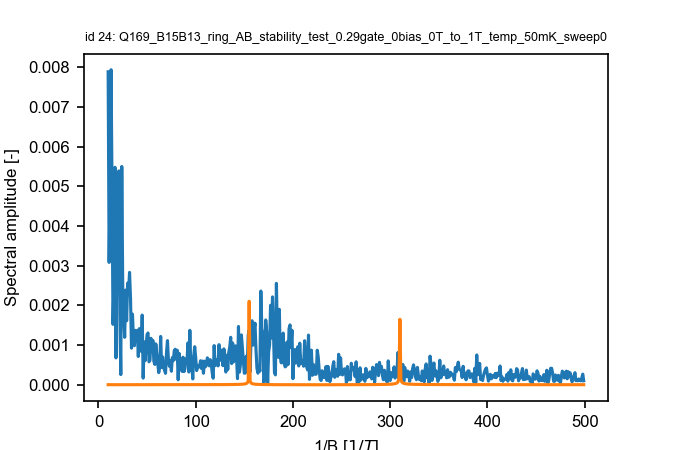

In [308]:
import scipy.optimize as optimize

dat_AB = load_by_id(24);
B_x = np.array(dat_AB.get_values('B_x'))[:,0];
G = np.array(dat_AB.get_values('conductance'))[:,0]

B_fft_int = np.linspace(0, 1000, 1001);
n_cut = int(np.floor(len(B_fft_int) / 2));

B_fft = np.linspace(0, B_x.size / (max(B_x) - min(B_x)), B_x.size);
G_fft = np.abs(np.fft.fft(G)) / len(G);

G_fft_int = np.interp(B_fft_int, B_fft, G_fft);
G_fft_int_area = sum(G_fft_int);

def G_model(B, G_avg, B_0, c_0, c_1):
    return G_avg * (1 + c_0 * np.cos(B / B_0) + c_1 * np.cos(1/2 * B / B_0));

def G_model_fft(B, G_avg, B_0, c_0, c_1):
    this_fft = np.abs(np.fft.fft(G_model(B, G_avg, B_0, c_0, c_1))) / len(B);
    return this_fft;

def G_model_fft_sum(B, G_avg, B_0, c_0, c_1):
    return sum(G_model_fft(B, G_avg, B_0, c_0, c_1));

p_guess = [np.average(G), 1/2000, 1, 1];
p_fit = optimize.curve_fit(G_model_fft_sum, B_fft_int, G_fft_int, p0 = p_guess)[0];
print(p_fit);

n_plot_init = 10;

fig = plt.figure('AB_Fourier_fit');
plt.plot(B_fft_int[n_init:n_cut], G_fft_int[n_plot_init:n_cut]);
plt.plot(B_fft_int[n_init:n_cut], G_model_fft(B_fft_int, *p_fit)[n_plot_init:n_cut]*10);
plt.xlabel('1/B [$1/T$]');
plt.ylabel('Spectral amplitude [-]');
plt.title('id '+str(dat_AB.run_id)+': '+dat_AB.exp_name, fontdict = {'fontsize': 6});

# Hall measurements

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


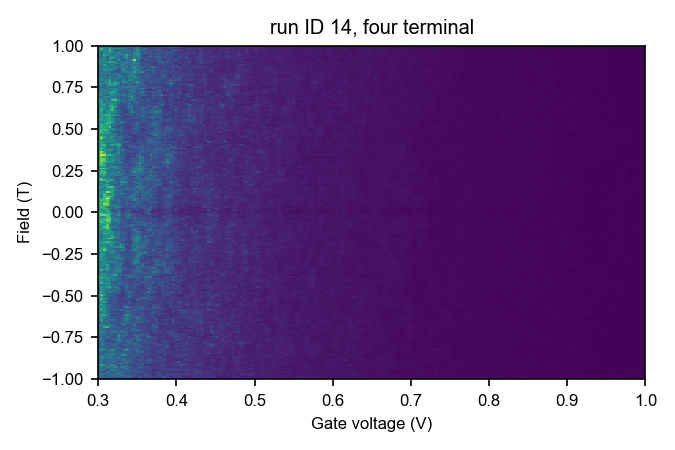

Text(0.5,1,'run ID 14, four terminal')

In [681]:
# pinchoff

qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\experiments_2018-10.db')
# automatically uses a different DB file for each month
initialise_database()
# creates a new DB file if nonexistant; leaves it untouched if file already exists

dat_Hall = load_by_id(14)
VG_fs = np.unique(np.array(dat_Hall.get_values('mdac_gate_voltage'))[:,0])
B_ss = np.unique(np.array(dat_Hall.get_values('AMI430_x_field'))[:,0])
Rxx = np.reshape(np.array(dat_Hall.get_values('R_xx'))[:,0], (len(B_ss), len(VG_fs)))
# Rxx = np.fliplr(Rxx) # Gate was swept from high to low, but np.unique sorts it from low to high
Rxy = np.reshape(np.array(dat_Hall.get_values('R_xy'))[:,0], (len(B_ss), len(VG_fs)))
#Rxy = np.fliplr(Rxy)

plt.figure('hall pinchoff')
plt.pcolor(VG_fs, B_ss, Rxx)
plt.xlabel('Gate voltage (V)')
plt.ylabel('Field (T)')
plt.title('run ID {}, four terminal'.format(dat_Hall.run_id))
#plt.grid(b=True)

In [637]:
VG_fs.shape
B_ss.shape
Rxx.shape

(97, 201)

## Mobility from transconductance

$$ R_{xx} = \frac{1}{\sigma} \frac{L_{xx}}{tW}$$

$$\sigma = ne\mu$$

$$ne = Q/(L_{xx}tW) = \frac{1}{L_{xx}tW} \int_{V_{th}}^{V_g} CdV$$

Combined they give $$\frac{\partial G_{xx}}{\partial V_g} = \frac{C\mu}{L_{xx}^2}$$

In [616]:
L_xx = 1.98e-6 # unit: m
C=1e-15 # F

smooth_window_size_1 = 31
smooth_window_size_2 = 21

Gxx_smooth = smooth(1/Rxx/12906.4, 31, 1)
plt.figure('transcond')
plt.plot(VG, Gxx_smooth)
Gxx_trans = (Gxx_smooth[1:]-Gxx_smooth[:-1])/ ((np.max(VG) - np.min(VG))/VG.size)

mu = smooth(np.power(L_xx,2) * Gxx_trans / C *1e4, 21, 1) #1e4 factor: m^2 to cm^2
plt.plot(VG[:-1], mu)
plt.title('Gate-dependent mobility from transconductance')
plt.xlabel('Gate (V)')
plt.ylabel('$\mu$ (cm$^2$/V*s)')
plt.grid(b=True)
plt.legend(['Conductance smoothening window size ={:d}'.format(smooth_window_size_1), 'Mobility smoothening window size ={:d}'.format(smooth_window_size_2)])

ValueError: object too deep for desired array

## Real Hall fitting

In [492]:
from qcodes.dataset.database import initialise_database, get_DB_location
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Code\BF3\Experiments\experiments_2018-10.db')
#qc.config["core"]["db_location"] = r'D:\Data\experiments_201808_and_older.db'
initialise_database()
# automatically uses a different DB file for each month

Plotting multiple field sweeps at different gates

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


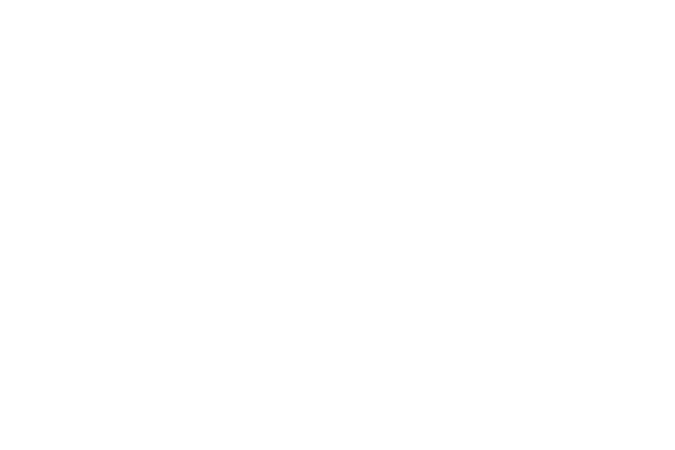

IndexError: list index out of range

In [584]:
gate_list = np.linspace(0.3,1,201)  
#gate_list = np.linspace(0,1,21)  
runID_list = [4]
#runID_list = np.arange(43,72)
#runID_list = np.arange(115,136)

Rxx_raw_list = []
Rxy_raw_list = []
B_raw_list = []

plt.figure('hall raw')
counter = 0
## FOR MULTIPLE DIFFERENT DATASETS
# for runID in runID_list:
#     dat_Hall = load_by_id(runID)
#     B_raw_list.append(np.array(dat_Hall.get_values('B_x'))[:,0])
#     Rxx_raw_list.append(np.array(dat_Hall.get_values('R_xx'))[:,0])
#     Rxy_raw_list.append(np.array(dat_Hall.get_values('R_xy'))[:,0])
#     plt.subplot(211)
#     plt.plot(B_raw_list[counter], Rxx_raw_list[counter])
#     plt.subplot(212)
#     plt.plot(B_raw_list[counter], Rxy_raw_list[counter])
#     counter += 1

## FOR USING LINECUTS FROM SINGLE 2D PLOT
rid = runID_list[4];
dat_Hall = load_by_id(rid);
gate_vals = np.unique(dat_Hall.get_values('mdac_gate_voltage'));
print(gate_vals.shape);


# plt.subplot(211)
# plt.ylabel('$R_{xx} (h/2e^2)$')
# plt.title('Run ID: {:d} to {:d}'.format(np.min(runID_list), np.max(runID_list)))
# plt.subplot(212)
# plt.ylabel('$R_{xy} (\Omega)$')
# plt.xlabel('$B_x$ (T)')

## Some basic Hall effect formulas

Links: [Hall effect](https://en.wikipedia.org/wiki/Hall_effect) and [mobility](https://en.wikipedia.org/wiki/Electron_mobility) Wikipedia pages.

$$ V_H = \frac{I_x B_z}{nte} $$

where $V_H$ is the Hall voltage, $I_x$ the current, $B_z$ perpendicular magnetic field, $n$ carrier density, $t$ thickness (height) of the wire and $e$ the electron charge. In our measurements, $R_{xy} \equiv V_H/I_x$, so fitting $R_{xy}$ and $B_z$ at any given $V_{TG}$ gives the coefficient $1/(nte)$.

From $\sigma = ne\mu$, we have $\mu=\sigma/(ne)$ where $\mu$ is the carrier (electron) mobility and $\sigma$ the conductivity.

To translate this into what we measure directly, 

$$\mu = \sigma t \frac{1}{nte} = \frac{L_{xx}}{R_{xx}W} \frac{1}{nte}$$

$1/(\sigma t)$ is also called the sheet resistance and obtained in our measurements as 

$$\sigma t = \frac{1}{R_{xx}} \frac{L_{xx}}{W}$$

where $R_{xx}$ is the longitudinal resistance via current-bias four-probe measurements, $L_{xx}$ is the distance between two XX leads (`length_xx` defined below) and $W$ the width of the nanowire.

So we first fit the linear coefficient $1/(nte)$ and then directly calculate $n$ and $\mu$ from it.

In [682]:
import scipy.optimize as optimize
import scipy.integrate as integrate
import scipy.fftpack as fft
import scipy.interpolate as interp
from scipy import stats
import re
#import spyview_data_import as data_import
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as colors

In [683]:
def doubleYAxisPlot(axLeft, x, yLeft, yRight, xLabel, yLabelLeft, yLabelRight):
    axRight = axLeft.twinx() # this creates another axes object that shares the same x axis and whose y ticks and labels are automatically set to be on the right
    plot_left, = axLeft.plot(x, yLeft, color='#1f77b4') # these are the default colors in matplotlib v2
    plot_right, = axRight.plot(x, yRight, color='#ff7f0e')
    axLeft.set_ylabel(yLabelLeft, color=plot_left.get_color())
    axRight.set_ylabel(yLabelRight, color=plot_right.get_color())
    axLeft.set_xlabel(xLabel)
    # set all tick labels, tick lines and spines to the same color as the plot line
    for t in axLeft.get_yticklabels(): 
        t.set_color(plot_left.get_color())
    for t in axLeft.get_yticklines():
        t.set_color(plot_left.get_color())
    for t in axRight.get_yticklabels():
        t.set_color(plot_right.get_color())
    for t in axRight.get_yticklines():
        t.set_color(plot_right.get_color())
    axLeft.spines['left'].set_color(plot_left.get_color())
    axRight.spines['right'].set_color(plot_right.get_color())
    return (axLeft, axRight)

In [674]:
gate_list.shape

(201,)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


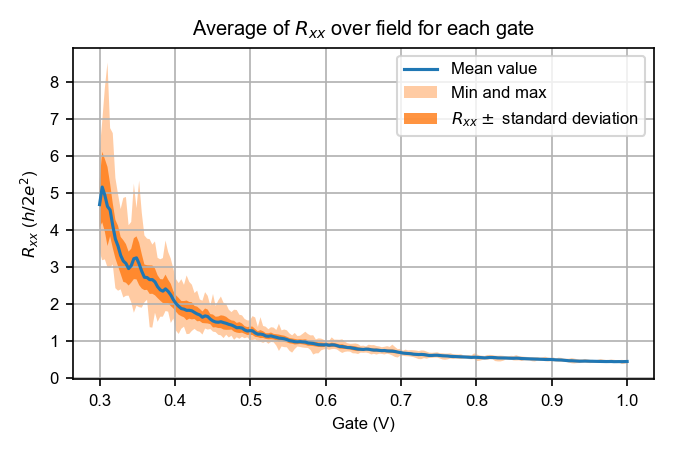

In [684]:
gate_list = VG_fs

Rxx_av_list = np.empty_like(gate_list)
Rxx_min_list = np.empty_like(gate_list)
Rxx_max_list = np.empty_like(gate_list)
Rxx_std_list = np.empty_like(gate_list)

for counter in range(0, len(gate_list)):
    Rxx_sym = (Rxx[:,counter] + Rxx[:,counter][::-1])/2
    #Rxx_sim = Rxx_raw_list[counter]
    Rxx_av_list[counter] = Rxx_sym.mean()
    Rxx_max_list[counter] = Rxx_sym.max()
    Rxx_min_list[counter] = Rxx_sym.min()
    Rxx_std_list[counter] = Rxx_sym.std()
    
plt.figure('Rxx average')
plt.plot(gate_list, Rxx_av_list)
plt.fill_between(gate_list, Rxx_min_list, Rxx_max_list, alpha=0.5, facecolor='#FF9848')
plt.fill_between(gate_list, Rxx_av_list-Rxx_std_list, Rxx_av_list+Rxx_std_list, alpha=0.8, facecolor='#FF7911')
plt.title('Average of $R_{xx}$ over field for each gate')
plt.xlabel('Gate (V)')
plt.ylabel('$R_{xx}$ ($h/2e^2$)')
plt.grid(b=True)
plt.legend(['Mean value', 'Min and max', '$R_{xx}\pm$ standard deviation'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


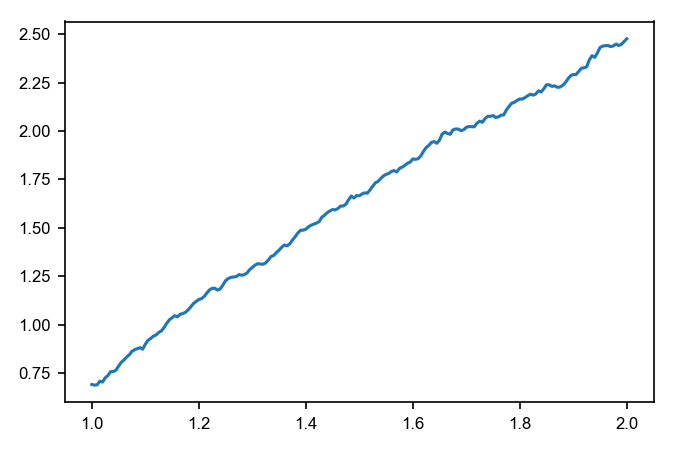

In [665]:
plt.figure('Hall pinchoff')
plt.plot(VG_fs, 1/Rxx_av_list)

In [685]:
# Here begins data processing, finally...

# First, define device geometry
# Length units: m
width_wire = 165e-9
#width_wire = 140e-9*2+100e-9
height_wire = 105e-9 # or "thickness", in usual 2D Hall language
#height_wire = 10e-9 # or "thickness", in usual 2D Hall language
length_SD = 2.7e-6 # length from source to drain
length_xx = 1.93e-6 # length between two xx leads (L1 and L2 in this case)

# calculate (the inverse of) the sheet resistance at each gate value
sigma_t = length_xx / (width_wire * Rxx_av_list*12906.4)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


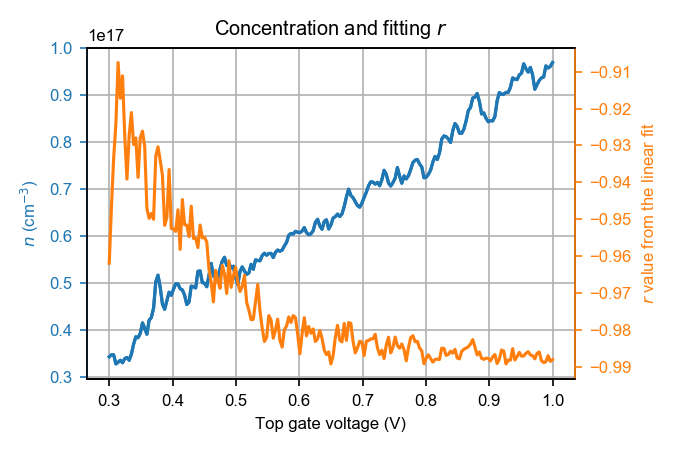

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [686]:
nte_inverse = np.empty_like(gate_list) # initializing the vector containing the 1/nte coefficients for each TG value
nte_fit_rval = np.empty_like(gate_list)
for i in range(0,gate_list.size):
    Rxy_asym = (Rxy[:,i] - Rxy[:,i][::-1])/2
    nte_inverse[i], intercept, nte_fit_rval[i], p_value, nte_fit_std_err = stats.linregress(B_ss, Rxy[:,i])
    #nte_inverse[i], intercept, nte_fit_rval[i], p_value, nte_fit_std_err = stats.linregress(B_raw_list[i], Rxy_asym)


concentration = np.abs(1e-6/(nte_inverse*e*height_wire)) # volume density

#conc_error = nte_fit_std_err * (1e-6/(e*height_wire)) * np.abs(np.power(nte_inverse, -2))
plt.figure('conc')
plt.plot(gate_list, concentration) # 1e-6 converts units from m^3 to cm^3
#plt.fill_between(gate_list, concentration-3*conc_error, concentration+3*conc_error, alpha=0.5, facecolor='#FF9848')
plt.xlabel('Top gate voltage (V)')
plt.ylabel('$n$ (cm$^{-3}$)')
plt.title('Carrier concentration (value + fitting uncertainty)')

plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_conc = plt.figure('conc')
ax_conc = fig_conc.add_subplot(111)
(ax_conc, ax_nte_rval) = doubleYAxisPlot(axLeft=ax_conc, \
                                   x=gate_list, yLeft=concentration, yRight=nte_fit_rval, \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$n$ (cm$^{-3}$)',\
                                   yLabelRight='$r$ value from the linear fit')
ax_conc.set_title('Concentration and fitting $r$')
ax_conc.grid(b=True)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


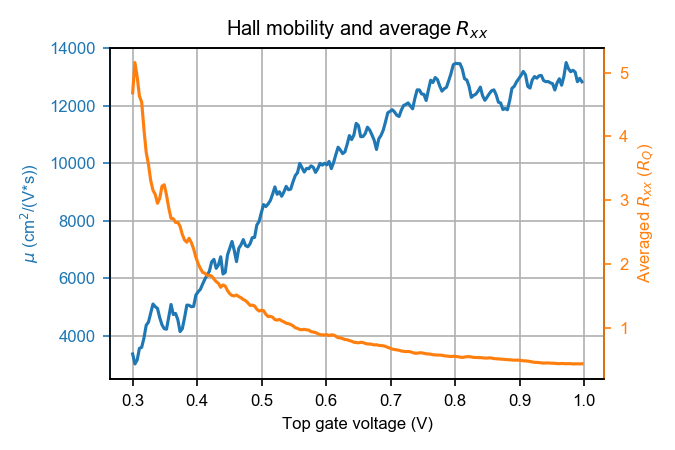

In [687]:
mu = np.abs(sigma_t * nte_inverse)*1e4

cut_neg_gates = 1 # number of columns of gate values to cut from the plots, 1 = no cutting
plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_mob = plt.figure('Rxx and mu')
ax_mob = fig_mob.add_subplot(111)
(ax_mob, ax_Rxx_average) = doubleYAxisPlot(axLeft=ax_mob, \
                                   x=gate_list[:-cut_neg_gates], yLeft=mu[:-cut_neg_gates], yRight=Rxx_av_list[:-cut_neg_gates], \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$\mu$ (cm$^2$/(V*s))',\
                                   yLabelRight='Averaged $R_{xx}$ ($R_Q$)')
ax_mob.set_title('Hall mobility and average $R_{xx}$')
ax_mob.grid(b=True)
#fig_mob.savefig('H6 Hall mob.pdf', format='pdf')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


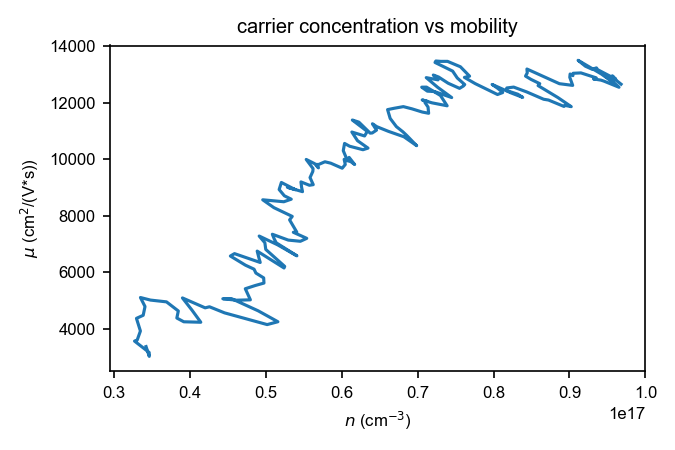

Text(0.5,1,'carrier concentration vs mobility')

In [688]:
plt.figure('n vs mu')
plt.plot(concentration, mu) # 1e-6 converts units from m^3 to cm^3
plt.xlabel('$n$ (cm$^{-3}$)')
plt.ylabel('$\mu$ (cm$^2$/(V*s))')
plt.title('carrier concentration vs mobility')
#plt.savefig('Q169 H1 n vs mu.pdf', format='pdf')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


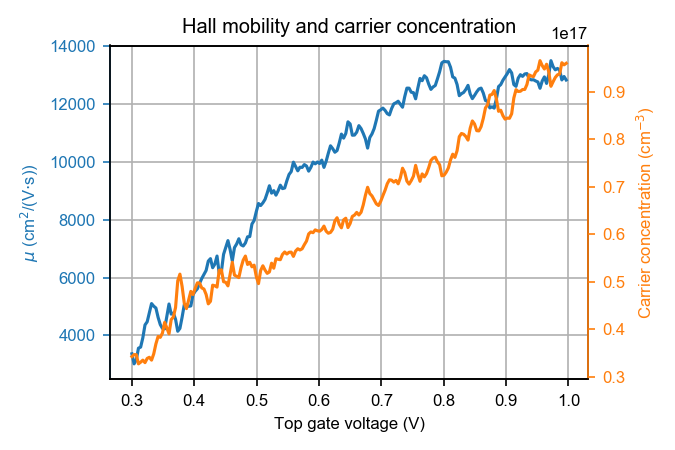

In [689]:
cut_neg_gates = 1 # number of columns of gate values to cut from the plots, 1 = no cutting
plt.rcParams.update({'figure.autolayout': True}) # make sure enough space is left at the boundaries to display all labels
fig_mob_conc = plt.figure('n and mu')
ax_mob_left = fig_mob_conc.add_subplot(111)
(ax_mob_left, ax_conc_right) = doubleYAxisPlot(axLeft=ax_mob_left, \
                                   x=gate_list[:-cut_neg_gates], yLeft=mu[:-cut_neg_gates], yRight=concentration[:-cut_neg_gates], \
                                   xLabel='Top gate voltage (V)', \
                                   yLabelLeft='$\mu$ (cm$^2$/(V$\cdot$s))',\
                                   yLabelRight='Carrier concentration (cm$^{-3}$)')
ax_mob_left.set_title('Hall mobility and carrier concentration')
ax_mob_left.grid(b=True)
#fig_mob_conc.savefig('Q169 n and mu.pdf', format='pdf')

<IPython.core.display.Javascript object>


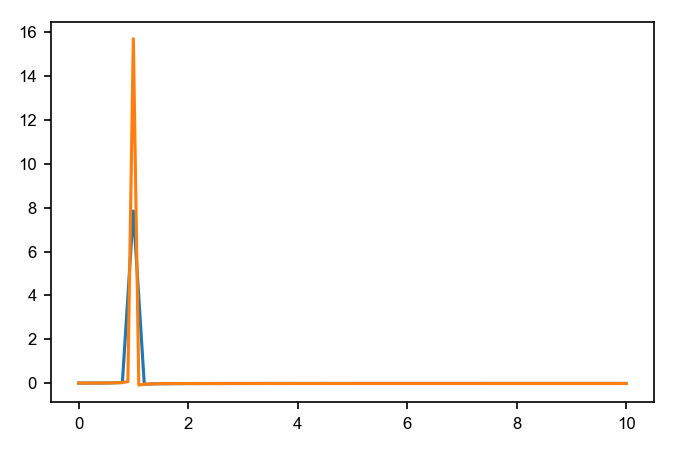

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [220]:
t1 = np.linspace(0,10*np.pi,1001)
t2 = np.linspace(0,20*np.pi,2001)

sin1, sin2 = np.sin(t1), np.sin(t2)

plt.figure('fft test')
F1, F2 = np.fft.fft(sin1), np.fft.fft(sin2)
w1, w2 = np.linspace(0,200,1001), np.linspace(0,200,2001)
plt.plot(w1[:51], F1[:51], w2[:101], F2[:101])